Neo4J v057 test1 - Data Analysis and Visualizing 
================

## Set up the environment


### Install py2neo for querying Neo4J 

In [3]:
#!pip3 install -U py2neo

# add python path of py2neo in system

#!pip3 install -U neotime
#!pip3 install -U neobolt
#!pip3 install -U xlrd

### Import Packages

In [4]:
from py2neo import Graph

from google.cloud import storage
import yaml

import pandas as pd
import numpy as np
import subprocess
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns

#plt.style.use('fivethirtyeight')
#plt.style.use('ggplot')
pd.set_option('display.float_format', lambda x: '%.2f' % x)

### Load Neo4J DB

In [5]:
# Option 1 : Read DB and Account Information in Google Storage (YAML)

# create storage client
storage_client = storage.Client()
# get bucket with name
bucket = storage_client.get_bucket('gbsc-gcp-project-mvp-{env}-trellis')
# get bucket data as blob
blob = bucket.get_blob('credentials/{env}-wgs35.yaml')
# convert to string
yaml_data = blob.download_as_string()

account = yaml.load(yaml_data, Loader=yaml.FullLoader)

## Main Account
graph = Graph(account['NEO4J_SCHEME']+'://'+account['NEO4J_HOST']+":"+str(account['NEO4J_PORT']), auth=(account['NEO4J_USER'],account['NEO4J_PASSPHRASE']))

--------
## Merge sample table and job table

In [6]:
sample_df=pd.read_csv('./sample-based-analysis-v057-simple.csv')
job_df=pd.read_csv('./job-based-analysis-v057.csv')

In [7]:
sample_pass=sample_df[['sample','pass']]
merged_df=pd.merge(sample_pass,job_df,left_on=['sample'],right_on=['sample'],how='right')
columnlist=['sample','pass','job','fq2urg_gatkid','dup','attempts','runtime','unit_runtime','dstat_status','dstat_msg','dstat_log']
merged_df=merged_df[columnlist]
#merged_df.head()

In [8]:
num_sample=len(merged_df['sample'].unique())
display(num_sample)

288

--------
## Duplication Analysis

### Duplication Count and Percentage

In [9]:
## Total Jobs
num_total_job=merged_df.loc[(merged_df['job']=='FQ2U')|(merged_df['job']=='GATK'),'job'].value_counts().to_frame()
#display(num_total_job)

## Duplicated Jobs (All, Pass, Fail)
num_dup_job=merged_df.loc[(merged_df['dup']==True)&((merged_df['job']=='FQ2U')|(merged_df['job']=='GATK')),'job'].value_counts().to_frame()
#display(num_dup_job)

num_dup_job_inpass=merged_df.loc[(merged_df['pass']=='pass')&(merged_df['dup']==True)&((merged_df['job']=='FQ2U')|(merged_df['job']=='GATK')),'job'].value_counts().to_frame()
#display(num_dup_job_inpass)

num_dup_job_infail=merged_df.loc[(merged_df['pass']=='fail')&(merged_df['dup']==True)&((merged_df['job']=='FQ2U')|(merged_df['job']=='GATK')),'job'].value_counts().to_frame()
#display(num_dup_job_infail)

### Histogram of duplicated jobs by sample and Runtime

In [10]:
## fq2u duplicated jobs
fq2u_dup=merged_df.loc[(merged_df['dup']==True)&(merged_df['job']=='FQ2U'),['sample','runtime']]
fq2u_dup_bysp=fq2u_dup['sample'].value_counts().to_frame()
fq2u_dup_bysp_freq=fq2u_dup_bysp['sample'].value_counts().to_frame().reset_index()
#display(fq2u_dup_bysp_freq)

## gatk duplicated jobs
gatk_dup=merged_df.loc[(merged_df['dup']==True)&(merged_df['job']=='GATK'),['sample','runtime']]
gatk_dup_bysp=gatk_dup['sample'].value_counts().to_frame()
gatk_dup_bysp_freq=gatk_dup_bysp['sample'].value_counts().to_frame().reset_index()
#display(gatk_dup_bysp_freq)

ValueError: min() arg is an empty sequence

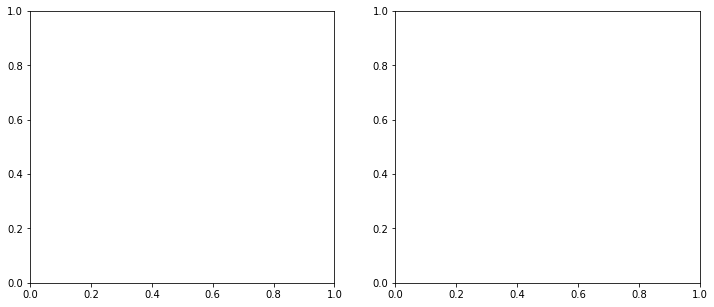

In [11]:
f, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

sns.barplot(x='index', y='sample', data=fq2u_dup_bysp_freq, palette="Blues_d", ax=axes[0]).set(xlim=(-1,4),ylim=(0,12))
axes[0].set_title('Histogram of Duplicated FQ2U Jobs', fontsize=18)
axes[0].set_ylabel('Number of samples ', fontsize=16)
axes[0].set_xlabel('Number of duplicated FQ2U jobs', fontsize=16)
plt.show

sns.barplot(x='index', y='sample', data=gatk_dup_bysp_freq, palette="Blues_d", ax=axes[1]).set(xlim=(-1,4),ylim=(0,12))
axes[1].set_title('Histogram of Duplicated GATK Jobs', fontsize=18)
axes[1].set_ylabel('Number of samples ', fontsize=16)
axes[1].set_xlabel('Number of duplicated GATK jobs', fontsize=16)
plt.show

In [12]:
#display(fq2u_dup)
#display(gatk_dup)

/usr/local/lib/python3.5/dist-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/usr/local/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<function matplotlib.pyplot.show(*args, **kw)>

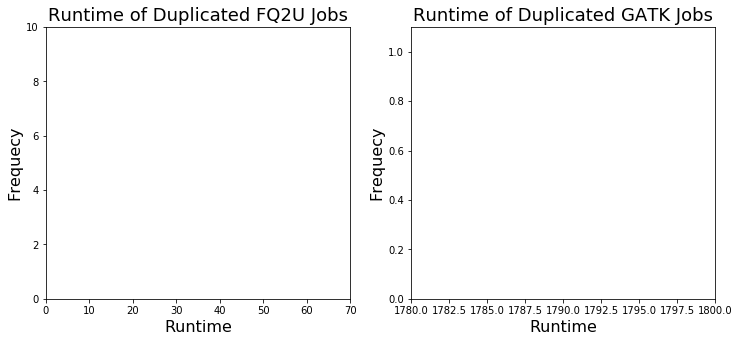

In [13]:
f, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.distplot(fq2u_dup.runtime, kde=False, ax=axes[0]).set(xlim=(0,70),ylim=(0,10));
axes[0].set_title('Runtime of Duplicated FQ2U Jobs', fontsize=18)
axes[0].set_ylabel('Frequecy', fontsize=16)
axes[0].set_xlabel('Runtime', fontsize=16)
plt.show

sns.distplot(gatk_dup.runtime, kde=False, ax=axes[1]).set(xlim=(1780,1800),ylim=(0,1.1));
axes[1].set_title('Runtime of Duplicated GATK Jobs', fontsize=18)
axes[1].set_ylabel('Frequecy', fontsize=16)
axes[1].set_xlabel('Runtime', fontsize=16)
plt.show

--------
## Runtime Analysis

### Distribution of FQ2U and GATK runtime 

In [14]:
## PASS case
fq2u_runtime_inpass=merged_df.loc[(merged_df['dstat_status']=='SUCCESS')&(merged_df['dup']!=True)&(merged_df['job']=='FQ2U'),'runtime']
gatk_runtime_inpass=merged_df.loc[(merged_df['pass']=='pass')&(merged_df['dup']!=True)&(merged_df['job']=='GATK'),'runtime']/60
                                                                                        
## FAIL case                                                                               
fq2u_runtime_infail=merged_df.loc[(merged_df['dstat_status']!='SUCCESS')&(merged_df['dup']!=True)&(merged_df['job']=='FQ2U'),'runtime']
gatk_runtime_infail=merged_df.loc[(merged_df['pass']=='fail')&(merged_df['dup']!=True)&(merged_df['job']=='GATK'),'runtime']/60                                                                                     

### Histogram of Runtime

/usr/local/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<function matplotlib.pyplot.show(*args, **kw)>

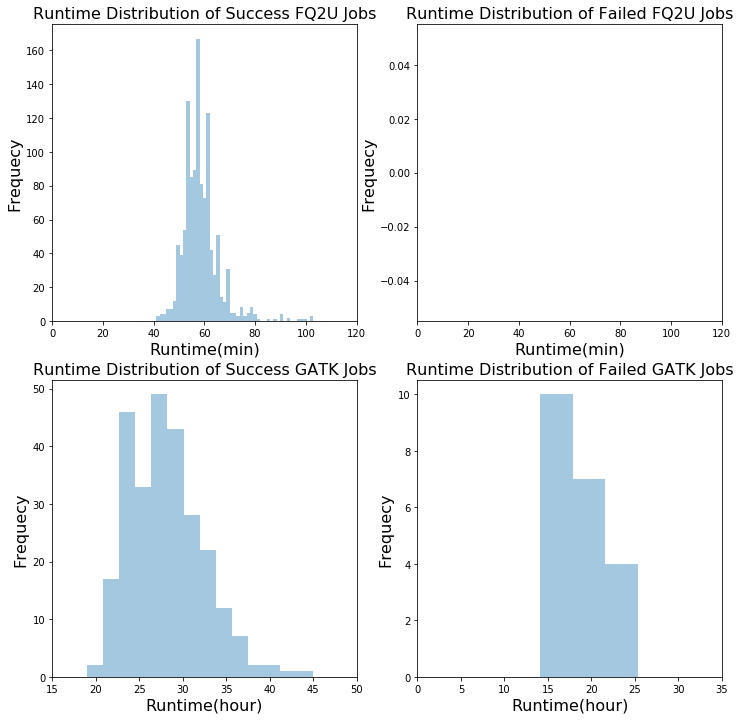

In [15]:
f, axes = plt.subplots(2, 2, figsize=(12, 12))

sns.distplot(fq2u_runtime_inpass, kde=False, ax=axes[0,0]).set(xlim=(0,120))
axes[0,0].set_title('Runtime Distribution of Success FQ2U Jobs', fontsize=16)
axes[0,0].set_ylabel('Frequecy', fontsize=16)
axes[0,0].set_xlabel('Runtime(min)', fontsize=16)
plt.show

sns.distplot(fq2u_runtime_infail, kde=False, ax=axes[0,1]).set(xlim=(0,120))
axes[0,1].set_title('Runtime Distribution of Failed FQ2U Jobs', fontsize=16)
axes[0,1].set_ylabel('Frequecy', fontsize=16)
axes[0,1].set_xlabel('Runtime(min)', fontsize=16)
plt.show

sns.distplot(gatk_runtime_inpass, kde=False, ax=axes[1,0]).set(xlim=(15,50))
axes[1,0].set_title('Runtime Distribution of Success GATK Jobs', fontsize=16)
axes[1,0].set_ylabel('Frequecy', fontsize=16)
axes[1,0].set_xlabel('Runtime(hour)', fontsize=16)
plt.show

sns.distplot(gatk_runtime_infail, kde=False, ax=axes[1,1]).set(xlim=(0,35))
axes[1,1].set_title('Runtime Distribution of Failed GATK Jobs', fontsize=16)
axes[1,1].set_ylabel('Frequecy', fontsize=16)
axes[1,1].set_xlabel('Runtime(hour)', fontsize=16)
plt.show

--------
## Attempts Analysis

### Add expected_vm and added_vm

In [16]:
## expected vm data frame
exp_vm_df=pd.read_excel("./GATKstep_expected_vm.xlsx")

In [17]:
merged_attemps_df=pd.merge(exp_vm_df,merged_df,left_on=['job'],right_on=['job'],how='right')
merged_attemps_df['added_vm']=merged_attemps_df['attempts']-merged_attemps_df['exp_vm']
columnlist=['sample','pass','job','fq2urg_gatkid','dup','attempts','exp_vm','added_vm','runtime','unit_runtime','dstat_status','dstat_msg','dstat_log']
merged_attemps_df=merged_attemps_df[columnlist]
#merged_attemps_df.head(2)

### Extract GATK substeps - code issue

In [18]:
gatk_substeps_df=merged_attemps_df.loc[(merged_attemps_df['job']!='FQ2U')|(merged_attemps_df['job']!='GATK'),:]

### Re-attempted work analysis

In [19]:
added_vm_df=gatk_substeps_df[['job','added_vm','exp_vm']]
added_vm_mean_df=added_vm_df.groupby('job').mean()
added_vm_mean_df['added_vm_ratio']=100*(np.array(added_vm_mean_df['added_vm'])/np.array(added_vm_mean_df['exp_vm']))
display(added_vm_mean_df)

,added_vm,exp_vm,added_vm_ratio
job,,,
FQ2U,nan,nan,nan
GATK,nan,nan,nan
applybqsr,0.83,20.00,4.14
baserecalibrator,0.81,19.00,4.26
checkcontamination,0.17,1.00,17.02
converttocram,0.09,1.00,9.02
createsequencegroupingtsv,0.00,1.00,0.35
gatherbamfiles,0.17,1.00,16.92
gatherbqsrreports,0.02,1.00,1.83


In [20]:
len(np.array(added_vm_df['added_vm']))
len(np.array(added_vm_df['exp_vm']))

5893

In [21]:
added_vm_perc=added_vm_mean_df.loc[added_vm_mean_df['added_vm'].notnull(),'added_vm_ratio'].reset_index().sort_values('job',ascending=False)
added_vm_perc.head()

,job,added_vm_ratio
15,validatecram,150.19
14,sumfloats,0.71
13,sortsamplebam,36.88
12,scatterintervallist,0.35
11,samtofastqandbwamemandmba,49.30


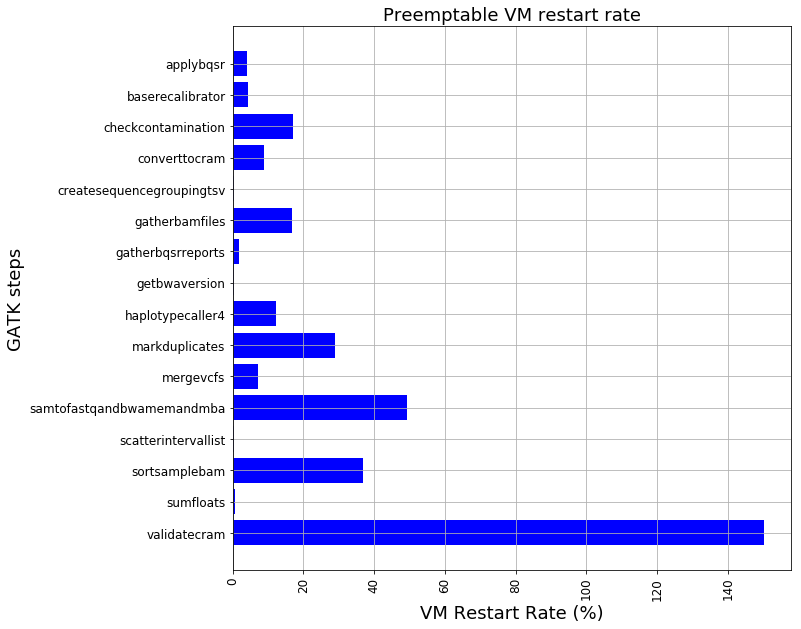

In [22]:
fig=plt.figure(figsize=(10, 10))
#ax.set_ylim(ax.get_ylim()[::-1])
plt.barh("job", "added_vm_ratio", data = added_vm_perc, color = "blue")
plt.xlabel("VM Restart Rate (%)", size=18)
plt.xticks(rotation = 90)
plt.ylabel("GATK steps", size=18)
plt.title("Preemptable VM restart rate", size=18)
plt.tick_params(axis='both', labelsize=12)
plt.grid(True)
plt.show()

--------
## Validation Cram Analysis

In [23]:
job_df=pd.read_csv('./job-based-analysis-v057.csv')

In [24]:
job_df.head()

,sample,job,fq2urg_gatkid,dup,attempts,runtime,unit_runtime,VMtype,dstat_status,dstat_msg,dstat_log
0,SHIP4946367,FQ2U,0,nan,nan,56.00,nan,custom-2-7680,SUCCESS,Success,gs://gbsc-gcp-project-mvp-test-from-personalis...
1,SHIP4946367,FQ2U,1,nan,nan,54.00,nan,custom-2-7680,SUCCESS,Success,gs://gbsc-gcp-project-mvp-test-from-personalis...
2,SHIP4946367,FQ2U,2,nan,nan,55.00,nan,custom-2-7680,SUCCESS,Success,gs://gbsc-gcp-project-mvp-test-from-personalis...
3,SHIP4946367,FQ2U,3,nan,nan,55.00,nan,custom-2-7680,SUCCESS,Success,gs://gbsc-gcp-project-mvp-test-from-personalis...
4,SHIP4946367,GATK,73470e9e-1a2d-4ad6-b55d-a8a3ddc54700,nan,nan,1705.00,nan,custom-2-12288,FAILURE,ient.googleapis.services.AbstractGoogleClient ...,gs://gbsc-gcp-project-mvp-test-from-personalis...


In [25]:
vcram_df=job_df.loc[job_df['job']=='validatecram',['attempts','runtime','dstat_status']]

,index,attempts
0,4.00,92
1,1.00,87
2,2.00,50
3,3.00,31
4,5.00,1


<function matplotlib.pyplot.show(*args, **kw)>

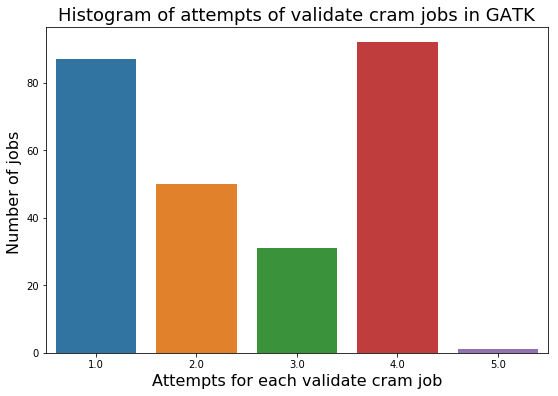

In [26]:
attempts_freq=vcram_df['attempts'].value_counts().to_frame()
attempts_freq.reset_index(inplace=True)
display(attempts_freq)
plt.figure(figsize=(9,6))

sns.barplot(x='index', y='attempts', data=attempts_freq)
# sns.distplot(vcram_df.attempts, kde=False);
plt.title('Histogram of attempts of validate cram jobs in GATK', fontsize=18)
plt.ylabel('Number of jobs ', fontsize=16)
plt.xlabel('Attempts for each validate cram job', fontsize=16)
plt.show

In [27]:
vcram_df=job_df.loc[(job_df['job']=='validatecram') & (job_df['dstat_status']=='SUCCESS'),['attempts','runtime','dstat_status']]

<function matplotlib.pyplot.show(*args, **kw)>

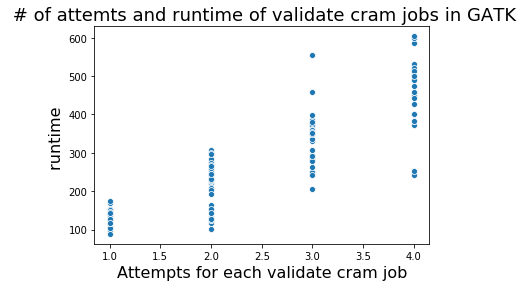

In [28]:
sns.scatterplot(x="attempts", y="runtime",data=vcram_df)

# sns.distplot(vcram_df.attempts, kde=False);
plt.title(' # of attemts and runtime of validate cram jobs in GATK', fontsize=18)
plt.ylabel('runtime ', fontsize=16)
plt.xlabel('Attempts for each validate cram job', fontsize=16)
plt.show

,index,attempts
0,1.00,79
1,2.00,47
2,3.00,29
3,4.00,26


<function matplotlib.pyplot.show(*args, **kw)>

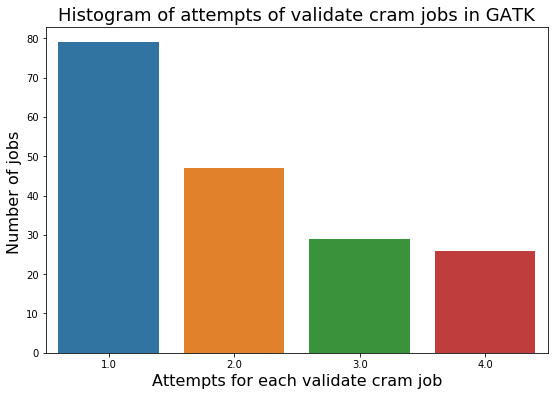

In [29]:
attempts_freq=vcram_df['attempts'].value_counts().to_frame()
attempts_freq.reset_index(inplace=True)
display(attempts_freq)
plt.figure(figsize=(9,6))

sns.barplot(x='index', y='attempts', data=attempts_freq)
# sns.distplot(vcram_df.attempts, kde=False);
plt.title('Histogram of attempts of validate cram jobs in GATK', fontsize=18)
plt.ylabel('Number of jobs ', fontsize=16)
plt.xlabel('Attempts for each validate cram job', fontsize=16)
plt.show

In [30]:
vcram_df=job_df.loc[(job_df['job']=='validatecram') & (job_df['dstat_status']=='FAILURE'),['attempts','runtime','dstat_status']]

<function matplotlib.pyplot.show(*args, **kw)>

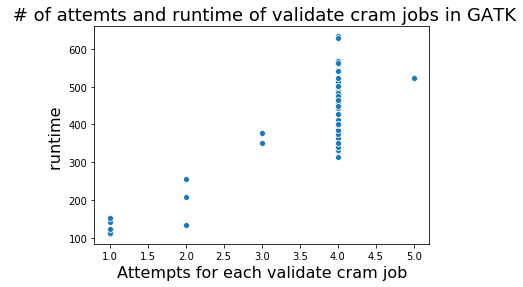

In [31]:
sns.scatterplot(x="attempts", y="runtime",data=vcram_df)

# sns.distplot(vcram_df.attempts, kde=False);
plt.title(' # of attemts and runtime of validate cram jobs in GATK', fontsize=18)
plt.ylabel('runtime ', fontsize=16)
plt.xlabel('Attempts for each validate cram job', fontsize=16)
plt.show

,index,attempts
0,4.00,66
1,1.00,8
2,2.00,3
3,3.00,2
4,5.00,1


<function matplotlib.pyplot.show(*args, **kw)>

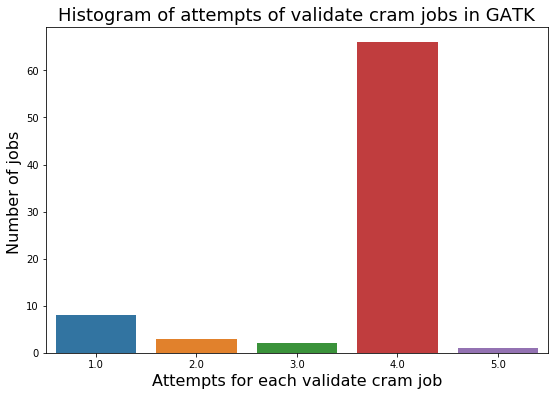

In [32]:
attempts_freq=vcram_df['attempts'].value_counts().to_frame()
attempts_freq.reset_index(inplace=True)
display(attempts_freq)
plt.figure(figsize=(9,6))

sns.barplot(x='index', y='attempts', data=attempts_freq)
# sns.distplot(vcram_df.attempts, kde=False);
plt.title('Histogram of attempts of validate cram jobs in GATK', fontsize=18)
plt.ylabel('Number of jobs ', fontsize=16)
plt.xlabel('Attempts for each validate cram job', fontsize=16)
plt.show

--------
## Attemps Analysis

--------
## Log Analysis (Temp)

In [33]:
sample_analysis_df=pd.read_csv('./sample-based-analysis-v057-withDupDstatLog.csv')

In [34]:
issued_log=sample_analysis_df.loc[(sample_analysis_df['status']=='success') & (sample_analysis_df['dstat_failed']=='GATK'),['sample','log']]

In [35]:
issued_log.reset_index(inplace=True)
display(issued_log.count())
display(issued_log.head(22))

index     81
sample    81
log       81
dtype: int64

,index,sample,log
0,3,SHIP5119449,gs://gbsc-gcp-project-mvp-test-from-personalis...
1,4,SHIP5141879,gs://gbsc-gcp-project-mvp-test-from-personalis...
2,7,SHIP4962324,gs://gbsc-gcp-project-mvp-test-from-personalis...
3,8,SHIP5119437,gs://gbsc-gcp-project-mvp-test-from-personalis...
4,10,SHIP4962327,gs://gbsc-gcp-project-mvp-test-from-personalis...
5,11,SHIP5119430,gs://gbsc-gcp-project-mvp-test-from-personalis...
6,18,SHIP5119451,gs://gbsc-gcp-project-mvp-test-from-personalis...
7,21,SHIP4962319,gs://gbsc-gcp-project-mvp-test-from-personalis...
8,26,SHIP5119442,gs://gbsc-gcp-project-mvp-test-from-personalis...
9,33,SHIP5141883,gs://gbsc-gcp-project-mvp-test-from-personalis...


In [36]:
f = open("./issued_log_success_v057.txt", 'w')
for s, i in enumerate(issued_log['log']):
    i = i + '/*out.log'
    try:
        f.write(str(issued_log['sample'][s])+'\n')
        f.write(str(subprocess.check_output('gsutil cat ' + i + '| grep "failed"', shell=True),'utf-8'))
        f.write('\n')
    except:
        continue
f.close()

# for log in success_issued_log['log'][0:1]:
#     log = log + '/*out.log'
#     print(log)
#     !gsutil cat gs://gbsc-gcp-project-mvp-test-from-personalis-wgs35-logs/DVALABP000398/SHIP4946378/gatk-5-dollar/200202-230755-888-c8678bdf/logs/*[0-9].log | grep 'error'


In [37]:
failed_log=sample_analysis_df.loc[(sample_analysis_df['pass']=='fail'),['sample','log']]

In [38]:
failed_log.reset_index(inplace=True)
display(failed_log.count())
display(failed_log.head(22))

index     23
sample    23
log       21
dtype: int64

,index,sample,log
0,5,SHIP4962321,gs://gbsc-gcp-project-mvp-test-from-personalis...
1,9,SHIP5119432,gs://gbsc-gcp-project-mvp-test-from-personalis...
2,17,SHIP5119457,gs://gbsc-gcp-project-mvp-test-from-personalis...
3,23,SHIP5119431,NaN
4,35,SHIP5119477,gs://gbsc-gcp-project-mvp-test-from-personalis...
5,48,SHIP4962334,gs://gbsc-gcp-project-mvp-test-from-personalis...
6,55,SHIP5141919,gs://gbsc-gcp-project-mvp-test-from-personalis...
7,62,SHIP5141911,gs://gbsc-gcp-project-mvp-test-from-personalis...
8,66,SHIP5141910,gs://gbsc-gcp-project-mvp-test-from-personalis...
9,93,SHIP5119466,gs://gbsc-gcp-project-mvp-test-from-personalis...


In [39]:
f = open("./failed_log_success_v057.txt", 'w')
for s, i in enumerate(failed_log['log']):
    try:
        i = i + '/*out.log'
        f.write(str(failed_log['sample'][s])+'\n')
        f.write(str(subprocess.check_output('gsutil cat ' + i + '| grep "failed"', shell=True),'utf-8'))
        f.write('\n')
    except:
        continue
f.close()

# for log in success_issued_log['log'][0:1]:
#     log = log + '/*out.log'
#     print(log)
#     !gsutil cat gs://gbsc-gcp-project-mvp-test-from-personalis-wgs35-logs/DVALABP000398/SHIP4946378/gatk-5-dollar/200202-230755-888-c8678bdf/logs/*[0-9].log | grep 'error'
